In [6]:
import feature_extraction as fe

import numpy as np

import os
import random
import pickle
import warnings
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seed = 3
random.seed(seed)
torch.manual_seed(seed)

warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [7]:
def data_batcher(data, batch_size):
    random.shuffle(data)
    return [data[i:i + batch_size] for i in range(0, len(data), batch_size)]

In [114]:
import pandas as pd

dataset = 'FMA_small'
dataset_filename = f'../datasets/{dataset}.gui'

In [99]:
[int(s[:-3]) for s in os.listdir(f'../datasets/{dataset}/')]

[108478,
 107597,
 133968,
 64840,
 9721,
 75437,
 66646,
 123970,
 135227,
 13362,
 64592,
 113357,
 16895,
 88856,
 109957,
 9962,
 14693,
 147023,
 70303,
 72206,
 56273,
 115849,
 45393,
 54376,
 108429,
 135336,
 107954,
 2,
 66757,
 140583,
 58221,
 123762,
 132787,
 130682,
 54236,
 109906,
 126225,
 137151,
 142535,
 135054,
 139043,
 107535,
 116490,
 81085,
 132774,
 54154,
 144179,
 55238,
 58052,
 142564,
 149082,
 75755,
 46158,
 120778,
 127289,
 25028,
 72135,
 81194,
 40986,
 52409,
 79593,
 72075,
 133449,
 113035,
 130923,
 26301,
 124231,
 140626,
 58215,
 7487,
 116457,
 47073,
 121653,
 140925,
 145003,
 56247,
 114412,
 72232,
 116517,
 86762,
 111377,
 113272,
 114880,
 98668,
 42844,
 45127,
 121593,
 109963,
 118986,
 131919,
 61012,
 63117,
 123647,
 49070,
 75403,
 56034,
 96698,
 126300,
 71228,
 119988,
 37041,
 122498,
 86680,
 146019,
 122649,
 9477,
 126240,
 24370,
 6609,
 142550,
 65779,
 47200,
 12189,
 1069,
 43598,
 72290,
 75862,
 54160,
 68682,
 1

In [129]:
df = pd.read_csv('../datasets/tracks.csv', sep=',', header=[0,1,2])
df_ids = df['Unnamed: 0_level_0']['Unnamed: 0_level_1']['track_id']
df_genres = df['track']['genre_top']['Unnamed: 40_level_2']
df = pd.concat([df_ids, df_genres], axis=1, sort=False)
df.rename(columns={'Unnamed: 40_level_2': 'genre', 'track_id': 'name'}, inplace=True)
df['name'] = df['name'].apply(lambda x: 'FMA_small/'+format(int(x), '07d')+'.au')

In [131]:
df

,name,genre
0,FMA_small/0000002.au,Hip-Hop
1,FMA_small/0000003.au,Hip-Hop
2,FMA_small/0000005.au,Hip-Hop
3,FMA_small/0000010.au,Pop
4,FMA_small/0000020.au,NaN
5,FMA_small/0000026.au,NaN
6,FMA_small/0000030.au,NaN
7,FMA_small/0000046.au,NaN
8,FMA_small/0000048.au,NaN
9,FMA_small/0000134.au,Hip-Hop


In [127]:
[format(int(s[:-3]), '07d') for s in os.listdir(f'../datasets/{dataset}/')]

['0108478',
 '0107597',
 '0133968',
 '0064840',
 '0009721',
 '0075437',
 '0066646',
 '0123970',
 '0135227',
 '0013362',
 '0064592',
 '0113357',
 '0016895',
 '0088856',
 '0109957',
 '0009962',
 '0014693',
 '0147023',
 '0070303',
 '0072206',
 '0056273',
 '0115849',
 '0045393',
 '0054376',
 '0108429',
 '0135336',
 '0107954',
 '0000002',
 '0066757',
 '0140583',
 '0058221',
 '0123762',
 '0132787',
 '0130682',
 '0054236',
 '0109906',
 '0126225',
 '0137151',
 '0142535',
 '0135054',
 '0139043',
 '0107535',
 '0116490',
 '0081085',
 '0132774',
 '0054154',
 '0144179',
 '0055238',
 '0058052',
 '0142564',
 '0149082',
 '0075755',
 '0046158',
 '0120778',
 '0127289',
 '0025028',
 '0072135',
 '0081194',
 '0040986',
 '0052409',
 '0079593',
 '0072075',
 '0133449',
 '0113035',
 '0130923',
 '0026301',
 '0124231',
 '0140626',
 '0058215',
 '0007487',
 '0116457',
 '0047073',
 '0121653',
 '0140925',
 '0145003',
 '0056247',
 '0114412',
 '0072232',
 '0116517',
 '0086762',
 '0111377',
 '0113272',
 '0114880',
 '00

In [132]:
df_export = df[df['name'].isin(['FMA_small/'+format(int(s[:-3]), '07d')+'.au' for s in os.listdir(f'../datasets/{dataset}/')])]
df_export

,name,genre
0,FMA_small/0000002.au,Hip-Hop
2,FMA_small/0000005.au,Hip-Hop
3,FMA_small/0000010.au,Pop
15,FMA_small/0000140.au,Folk
16,FMA_small/0000141.au,Folk
22,FMA_small/0000148.au,Experimental
55,FMA_small/0000182.au,Rock
61,FMA_small/0000190.au,Folk
64,FMA_small/0000193.au,Folk
65,FMA_small/0000194.au,Folk


In [133]:
df_export.to_csv('../datasets/FMA_Small.gui',sep=';', index=False)

In [112]:
df

,name,genre
0,FMA_small/00002.au,Hip-Hop
1,FMA_small/00003.au,Hip-Hop
2,FMA_small/00005.au,Hip-Hop
3,FMA_small/00010.au,Pop
4,FMA_small/00020.au,NaN
5,FMA_small/00026.au,NaN
6,FMA_small/00030.au,NaN
7,FMA_small/00046.au,NaN
8,FMA_small/00048.au,NaN
9,FMA_small/00134.au,Hip-Hop


In [12]:
dataset = 'GTZAN'
new_feats = False


dataset_filename = f'../datasets/{dataset}.gui'
pickle_filename = f'./feats_spects-pickles/{dataset_filename.split("/")[-1][:-4]}_feats.pkl'
if new_feats or not os.path.isfile(pickle_filename):
    feats, labels = fe.extract_numfeats(dataset_filename)
    with open(pickle_filename, 'wb') as f:
        pickle.dump([feats, labels], f)
else:
    with open(pickle_filename, 'rb') as f:
        feats, labels = pickle.load(f)
    print(f'{feats.shape[0]} features extracted')

Currently processing:  100
Currently processing:  200
Currently processing:  300
Currently processing:  400
Currently processing:  500
Currently processing:  600
Currently processing:  700
Currently processing:  800
Currently processing:  900
Currently processing:  1000


In [15]:
scaler = StandardScaler()
scaled_feats = scaler.fit_transform(feats)

x_trainval, x_test, y_trainval, y_test = train_test_split(scaled_feats, labels, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_trainval, y_trainval, test_size=0.25)

train_data = [(x, y) for x, y in zip(x_train, y_train)]
val_data = [(x, y) for x, y in zip(x_val, y_val)]
test_data = [(x, y) for x, y in zip(x_test, y_test)]

print(len(train_data), "training samples")
print(len(val_data), "validation samples")
print(len(test_data), "test samples")

600 training samples
200 validation samples
200 test samples


In [16]:
# Fully connected neural network with one hidden layer
class DNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(DNNClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = nn.Linear(hidden_size[1], hidden_size[2])
        self.fc4 = nn.Linear(hidden_size[2], hidden_size[3])
        self.fc5 = nn.Linear(hidden_size[3], num_classes)
        
        self.bn2 = nn.BatchNorm1d(hidden_size[1])
        self.bn3 = nn.BatchNorm1d(hidden_size[2])
        self.bn4 = nn.BatchNorm1d(hidden_size[3])
        
        self.drop_layer = nn.Dropout(p=0.5)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop_layer(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.drop_layer(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.drop_layer(x)
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.fc5(x)
        return x # we can return here the softmax, but then we should use the nll_loss instead of the cross_entropy

In [17]:
def train(log_interval, model, device, data_batches, optimizer, epoch):
    losses = []
    len_glob_data = np.prod(np.array(np.array(data_batches).shape[:-1]))
    
    model.train()
    
    for i, batch in enumerate(data_batches):
        x, y = list(zip(*batch))
        
        # Move tensors to the configured device
        data = torch.from_numpy(np.array(x)).float().to(device)
        target = torch.from_numpy(np.array(y)).to(device)
        
        # clear all the gradients of the optimized tensors
        optimizer.zero_grad()
    
        # Forward pass
        output = model(data)
        loss = criterion(output, target)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if (i+1) % log_interval == 0:
            print(f'Train Epoch: {epoch+1} [{(i+1)*len(data)}/{len_glob_data} ({str(int(100. * (i+1)*len(data) / len_glob_data)).zfill(2)}%)]\tLoss: {round(loss.item(),6)}')
    return np.array(losses).mean()

In [18]:
def validate(model, device, data_batches):
    len_glob_data = np.prod(np.array(np.array(data_batches).shape[:-1]))
    
    model.eval()  # let's put the model in evaluation mode

    validation_loss = []
    correct = 0
    with torch.no_grad():  # we don't need gradient computation at all
        for i, batch in enumerate(data_batches):
            x, y = list(zip(*batch))
        
            data = torch.from_numpy(np.array(x)).float().to(device)
            target = torch.from_numpy(np.array(y)).to(device)
            
            output = model(data)
            loss = criterion(output, target)
            
            validation_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss = np.array(validation_loss).mean()
    accuracy = 100. * correct / len_glob_data

    print(f'\nValidation set: Average loss: {round(validation_loss, 4)}, Accuracy: {correct}/{len_glob_data} ({int(accuracy)}%)\n')
    
    return accuracy, validation_loss

In [19]:
def test(model, device, data_batches):
    len_glob_data = np.prod(np.array(np.array(data_batches).shape[:-1]))
    
    model.eval()  # let's put the model in evaluation mode

    correct = 0
    with torch.no_grad():  # we don't need gradient computation at all
        for i, batch in enumerate(data_batches):
            x, y = list(zip(*batch))
        
            data = torch.from_numpy(np.array(x)).float().to(device)
            target = torch.from_numpy(np.array(y)).to(device)
            
            output = model(data)
            loss = criterion(output, target)
            
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = 100. * correct / len_glob_data

    print(f'Test set: Accuracy: {correct}/{len_glob_data} ({int(accuracy)}%)\n')
    
    return accuracy

In [20]:
# Hyperparameters

input_size = 25
hidden_size = [256, 128, 64, 32]
num_classes = 10

train_batch_size = 100
valid_batch_size = 100

num_epochs = 2000
learning_rate = 0.0001

In [21]:
train_data_batches = data_batcher(train_data, train_batch_size)
val_data_batches = data_batcher(val_data, valid_batch_size)

model = DNNClassifier(input_size, hidden_size, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
valid_losses = []
accuracies = []

for epoch in range(num_epochs):
    
    train_loss = train(2, model, device, train_data_batches, optimizer, epoch)
    train_losses.append(train_loss)

    accuracy, valid_loss = validate(model, device, val_data_batches)
    valid_losses.append(valid_loss)
    accuracies.append(accuracy)

Train Epoch: 1 [200/600 (33%)]	Loss: 2.309147
Train Epoch: 1 [400/600 (66%)]	Loss: 2.346429
Train Epoch: 1 [600/600 (100%)]	Loss: 2.336897

Validation set: Average loss: 2.3169, Accuracy: 12/200 (6%)

Train Epoch: 2 [200/600 (33%)]	Loss: 2.339664
Train Epoch: 2 [400/600 (66%)]	Loss: 2.333671
Train Epoch: 2 [600/600 (100%)]	Loss: 2.354272

Validation set: Average loss: 2.3164, Accuracy: 12/200 (6%)

Train Epoch: 3 [200/600 (33%)]	Loss: 2.298643
Train Epoch: 3 [400/600 (66%)]	Loss: 2.338499
Train Epoch: 3 [600/600 (100%)]	Loss: 2.327276

Validation set: Average loss: 2.3139, Accuracy: 12/200 (6%)

Train Epoch: 4 [200/600 (33%)]	Loss: 2.323509
Train Epoch: 4 [400/600 (66%)]	Loss: 2.326322
Train Epoch: 4 [600/600 (100%)]	Loss: 2.312782

Validation set: Average loss: 2.3093, Accuracy: 12/200 (6%)

Train Epoch: 5 [200/600 (33%)]	Loss: 2.281854
Train Epoch: 5 [400/600 (66%)]	Loss: 2.289156
Train Epoch: 5 [600/600 (100%)]	Loss: 2.327577

Validation set: Average loss: 2.3036, Accuracy: 15/200 (

Train Epoch: 43 [400/600 (66%)]	Loss: 2.161934
Train Epoch: 43 [600/600 (100%)]	Loss: 2.13964

Validation set: Average loss: 2.1584, Accuracy: 51/200 (25%)

Train Epoch: 44 [200/600 (33%)]	Loss: 2.171492
Train Epoch: 44 [400/600 (66%)]	Loss: 2.15426
Train Epoch: 44 [600/600 (100%)]	Loss: 2.1635

Validation set: Average loss: 2.1527, Accuracy: 52/200 (26%)

Train Epoch: 45 [200/600 (33%)]	Loss: 2.17679
Train Epoch: 45 [400/600 (66%)]	Loss: 2.208874
Train Epoch: 45 [600/600 (100%)]	Loss: 2.148686

Validation set: Average loss: 2.1489, Accuracy: 51/200 (25%)

Train Epoch: 46 [200/600 (33%)]	Loss: 2.155883
Train Epoch: 46 [400/600 (66%)]	Loss: 2.145129
Train Epoch: 46 [600/600 (100%)]	Loss: 2.159869

Validation set: Average loss: 2.1461, Accuracy: 52/200 (26%)

Train Epoch: 47 [200/600 (33%)]	Loss: 2.141007
Train Epoch: 47 [400/600 (66%)]	Loss: 2.133292
Train Epoch: 47 [600/600 (100%)]	Loss: 2.143222

Validation set: Average loss: 2.1413, Accuracy: 55/200 (27%)

Train Epoch: 48 [200/600 (3

Train Epoch: 83 [600/600 (100%)]	Loss: 1.987926

Validation set: Average loss: 2.0311, Accuracy: 64/200 (32%)

Train Epoch: 84 [200/600 (33%)]	Loss: 2.06814
Train Epoch: 84 [400/600 (66%)]	Loss: 2.034977
Train Epoch: 84 [600/600 (100%)]	Loss: 2.021428

Validation set: Average loss: 2.0265, Accuracy: 64/200 (32%)

Train Epoch: 85 [200/600 (33%)]	Loss: 2.012605
Train Epoch: 85 [400/600 (66%)]	Loss: 2.018087
Train Epoch: 85 [600/600 (100%)]	Loss: 2.010822

Validation set: Average loss: 2.0254, Accuracy: 64/200 (32%)

Train Epoch: 86 [200/600 (33%)]	Loss: 2.051303
Train Epoch: 86 [400/600 (66%)]	Loss: 2.029483
Train Epoch: 86 [600/600 (100%)]	Loss: 2.008851

Validation set: Average loss: 2.012, Accuracy: 64/200 (32%)

Train Epoch: 87 [200/600 (33%)]	Loss: 2.049525
Train Epoch: 87 [400/600 (66%)]	Loss: 2.02658
Train Epoch: 87 [600/600 (100%)]	Loss: 2.043202

Validation set: Average loss: 2.0109, Accuracy: 64/200 (32%)

Train Epoch: 88 [200/600 (33%)]	Loss: 2.007453
Train Epoch: 88 [400/600 

Train Epoch: 123 [400/600 (66%)]	Loss: 1.942419
Train Epoch: 123 [600/600 (100%)]	Loss: 1.860851

Validation set: Average loss: 1.9157, Accuracy: 64/200 (32%)

Train Epoch: 124 [200/600 (33%)]	Loss: 1.93582
Train Epoch: 124 [400/600 (66%)]	Loss: 1.931129
Train Epoch: 124 [600/600 (100%)]	Loss: 1.88669

Validation set: Average loss: 1.9094, Accuracy: 64/200 (32%)

Train Epoch: 125 [200/600 (33%)]	Loss: 1.908831
Train Epoch: 125 [400/600 (66%)]	Loss: 1.945725
Train Epoch: 125 [600/600 (100%)]	Loss: 1.867648

Validation set: Average loss: 1.9032, Accuracy: 64/200 (32%)

Train Epoch: 126 [200/600 (33%)]	Loss: 1.970386
Train Epoch: 126 [400/600 (66%)]	Loss: 1.93764
Train Epoch: 126 [600/600 (100%)]	Loss: 1.882604

Validation set: Average loss: 1.9037, Accuracy: 64/200 (32%)

Train Epoch: 127 [200/600 (33%)]	Loss: 1.939814
Train Epoch: 127 [400/600 (66%)]	Loss: 1.909921
Train Epoch: 127 [600/600 (100%)]	Loss: 1.867613

Validation set: Average loss: 1.8953, Accuracy: 65/200 (32%)

Train Epoch

Train Epoch: 165 [400/600 (66%)]	Loss: 1.807885
Train Epoch: 165 [600/600 (100%)]	Loss: 1.719828

Validation set: Average loss: 1.789, Accuracy: 72/200 (36%)

Train Epoch: 166 [200/600 (33%)]	Loss: 1.787228
Train Epoch: 166 [400/600 (66%)]	Loss: 1.786471
Train Epoch: 166 [600/600 (100%)]	Loss: 1.74385

Validation set: Average loss: 1.7868, Accuracy: 72/200 (36%)

Train Epoch: 167 [200/600 (33%)]	Loss: 1.818877
Train Epoch: 167 [400/600 (66%)]	Loss: 1.818194
Train Epoch: 167 [600/600 (100%)]	Loss: 1.678852

Validation set: Average loss: 1.7875, Accuracy: 72/200 (36%)

Train Epoch: 168 [200/600 (33%)]	Loss: 1.837842
Train Epoch: 168 [400/600 (66%)]	Loss: 1.787242
Train Epoch: 168 [600/600 (100%)]	Loss: 1.711133

Validation set: Average loss: 1.7826, Accuracy: 72/200 (36%)

Train Epoch: 169 [200/600 (33%)]	Loss: 1.878717
Train Epoch: 169 [400/600 (66%)]	Loss: 1.771259
Train Epoch: 169 [600/600 (100%)]	Loss: 1.739933

Validation set: Average loss: 1.7787, Accuracy: 72/200 (36%)

Train Epoc

Train Epoch: 205 [400/600 (66%)]	Loss: 1.711947
Train Epoch: 205 [600/600 (100%)]	Loss: 1.615571

Validation set: Average loss: 1.6845, Accuracy: 82/200 (41%)

Train Epoch: 206 [200/600 (33%)]	Loss: 1.720347
Train Epoch: 206 [400/600 (66%)]	Loss: 1.717836
Train Epoch: 206 [600/600 (100%)]	Loss: 1.59443

Validation set: Average loss: 1.6838, Accuracy: 82/200 (41%)

Train Epoch: 207 [200/600 (33%)]	Loss: 1.701826
Train Epoch: 207 [400/600 (66%)]	Loss: 1.652765
Train Epoch: 207 [600/600 (100%)]	Loss: 1.627301

Validation set: Average loss: 1.6778, Accuracy: 82/200 (41%)

Train Epoch: 208 [200/600 (33%)]	Loss: 1.668722
Train Epoch: 208 [400/600 (66%)]	Loss: 1.740605
Train Epoch: 208 [600/600 (100%)]	Loss: 1.588679

Validation set: Average loss: 1.6744, Accuracy: 82/200 (41%)

Train Epoch: 209 [200/600 (33%)]	Loss: 1.693193
Train Epoch: 209 [400/600 (66%)]	Loss: 1.719743
Train Epoch: 209 [600/600 (100%)]	Loss: 1.628502

Validation set: Average loss: 1.6786, Accuracy: 83/200 (41%)

Train Epo

Train Epoch: 247 [400/600 (66%)]	Loss: 1.616766
Train Epoch: 247 [600/600 (100%)]	Loss: 1.514794

Validation set: Average loss: 1.5689, Accuracy: 89/200 (44%)

Train Epoch: 248 [200/600 (33%)]	Loss: 1.575348
Train Epoch: 248 [400/600 (66%)]	Loss: 1.643627
Train Epoch: 248 [600/600 (100%)]	Loss: 1.495448

Validation set: Average loss: 1.5629, Accuracy: 89/200 (44%)

Train Epoch: 249 [200/600 (33%)]	Loss: 1.538599
Train Epoch: 249 [400/600 (66%)]	Loss: 1.635013
Train Epoch: 249 [600/600 (100%)]	Loss: 1.455229

Validation set: Average loss: 1.5635, Accuracy: 90/200 (45%)

Train Epoch: 250 [200/600 (33%)]	Loss: 1.546544
Train Epoch: 250 [400/600 (66%)]	Loss: 1.62342
Train Epoch: 250 [600/600 (100%)]	Loss: 1.474256

Validation set: Average loss: 1.5647, Accuracy: 93/200 (46%)

Train Epoch: 251 [200/600 (33%)]	Loss: 1.617539
Train Epoch: 251 [400/600 (66%)]	Loss: 1.617208
Train Epoch: 251 [600/600 (100%)]	Loss: 1.475861

Validation set: Average loss: 1.5605, Accuracy: 95/200 (47%)

Train Epo

Train Epoch: 289 [400/600 (66%)]	Loss: 1.473261
Train Epoch: 289 [600/600 (100%)]	Loss: 1.445502

Validation set: Average loss: 1.4782, Accuracy: 102/200 (51%)

Train Epoch: 290 [200/600 (33%)]	Loss: 1.579242
Train Epoch: 290 [400/600 (66%)]	Loss: 1.523035
Train Epoch: 290 [600/600 (100%)]	Loss: 1.360692

Validation set: Average loss: 1.4733, Accuracy: 101/200 (50%)

Train Epoch: 291 [200/600 (33%)]	Loss: 1.457683
Train Epoch: 291 [400/600 (66%)]	Loss: 1.546083
Train Epoch: 291 [600/600 (100%)]	Loss: 1.423533

Validation set: Average loss: 1.4727, Accuracy: 102/200 (51%)

Train Epoch: 292 [200/600 (33%)]	Loss: 1.543011
Train Epoch: 292 [400/600 (66%)]	Loss: 1.507234
Train Epoch: 292 [600/600 (100%)]	Loss: 1.41207

Validation set: Average loss: 1.4742, Accuracy: 100/200 (50%)

Train Epoch: 293 [200/600 (33%)]	Loss: 1.494327
Train Epoch: 293 [400/600 (66%)]	Loss: 1.494433
Train Epoch: 293 [600/600 (100%)]	Loss: 1.38423

Validation set: Average loss: 1.4657, Accuracy: 105/200 (52%)

Train

Train Epoch: 329 [200/600 (33%)]	Loss: 1.410547
Train Epoch: 329 [400/600 (66%)]	Loss: 1.392534
Train Epoch: 329 [600/600 (100%)]	Loss: 1.31505

Validation set: Average loss: 1.3979, Accuracy: 110/200 (55%)

Train Epoch: 330 [200/600 (33%)]	Loss: 1.350465
Train Epoch: 330 [400/600 (66%)]	Loss: 1.424352
Train Epoch: 330 [600/600 (100%)]	Loss: 1.272927

Validation set: Average loss: 1.3946, Accuracy: 110/200 (55%)

Train Epoch: 331 [200/600 (33%)]	Loss: 1.345572
Train Epoch: 331 [400/600 (66%)]	Loss: 1.426496
Train Epoch: 331 [600/600 (100%)]	Loss: 1.364721

Validation set: Average loss: 1.3886, Accuracy: 110/200 (55%)

Train Epoch: 332 [200/600 (33%)]	Loss: 1.465499
Train Epoch: 332 [400/600 (66%)]	Loss: 1.450529
Train Epoch: 332 [600/600 (100%)]	Loss: 1.349268

Validation set: Average loss: 1.3885, Accuracy: 111/200 (55%)

Train Epoch: 333 [200/600 (33%)]	Loss: 1.350291
Train Epoch: 333 [400/600 (66%)]	Loss: 1.349212
Train Epoch: 333 [600/600 (100%)]	Loss: 1.307453

Validation set: Ave

Train Epoch: 371 [400/600 (66%)]	Loss: 1.294098
Train Epoch: 371 [600/600 (100%)]	Loss: 1.226667

Validation set: Average loss: 1.3236, Accuracy: 111/200 (55%)

Train Epoch: 372 [200/600 (33%)]	Loss: 1.355724
Train Epoch: 372 [400/600 (66%)]	Loss: 1.367792
Train Epoch: 372 [600/600 (100%)]	Loss: 1.196843

Validation set: Average loss: 1.3246, Accuracy: 113/200 (56%)

Train Epoch: 373 [200/600 (33%)]	Loss: 1.251857
Train Epoch: 373 [400/600 (66%)]	Loss: 1.38113
Train Epoch: 373 [600/600 (100%)]	Loss: 1.213793

Validation set: Average loss: 1.3212, Accuracy: 114/200 (57%)

Train Epoch: 374 [200/600 (33%)]	Loss: 1.401822
Train Epoch: 374 [400/600 (66%)]	Loss: 1.358264
Train Epoch: 374 [600/600 (100%)]	Loss: 1.304883

Validation set: Average loss: 1.3125, Accuracy: 112/200 (56%)

Train Epoch: 375 [200/600 (33%)]	Loss: 1.380324
Train Epoch: 375 [400/600 (66%)]	Loss: 1.316121
Train Epoch: 375 [600/600 (100%)]	Loss: 1.200577

Validation set: Average loss: 1.3133, Accuracy: 114/200 (57%)

Trai

Train Epoch: 412 [200/600 (33%)]	Loss: 1.299526
Train Epoch: 412 [400/600 (66%)]	Loss: 1.258324
Train Epoch: 412 [600/600 (100%)]	Loss: 1.174955

Validation set: Average loss: 1.2593, Accuracy: 115/200 (57%)

Train Epoch: 413 [200/600 (33%)]	Loss: 1.295668
Train Epoch: 413 [400/600 (66%)]	Loss: 1.256363
Train Epoch: 413 [600/600 (100%)]	Loss: 1.152651

Validation set: Average loss: 1.2625, Accuracy: 115/200 (57%)

Train Epoch: 414 [200/600 (33%)]	Loss: 1.260397
Train Epoch: 414 [400/600 (66%)]	Loss: 1.301576
Train Epoch: 414 [600/600 (100%)]	Loss: 1.147845

Validation set: Average loss: 1.2586, Accuracy: 116/200 (58%)

Train Epoch: 415 [200/600 (33%)]	Loss: 1.16944
Train Epoch: 415 [400/600 (66%)]	Loss: 1.264563
Train Epoch: 415 [600/600 (100%)]	Loss: 1.147871

Validation set: Average loss: 1.2616, Accuracy: 118/200 (59%)

Train Epoch: 416 [200/600 (33%)]	Loss: 1.20264
Train Epoch: 416 [400/600 (66%)]	Loss: 1.296503
Train Epoch: 416 [600/600 (100%)]	Loss: 1.192738

Validation set: Aver

Train Epoch: 455 [200/600 (33%)]	Loss: 1.149098
Train Epoch: 455 [400/600 (66%)]	Loss: 1.177588
Train Epoch: 455 [600/600 (100%)]	Loss: 1.117012

Validation set: Average loss: 1.207, Accuracy: 118/200 (59%)

Train Epoch: 456 [200/600 (33%)]	Loss: 1.116849
Train Epoch: 456 [400/600 (66%)]	Loss: 1.179737
Train Epoch: 456 [600/600 (100%)]	Loss: 1.083737

Validation set: Average loss: 1.2079, Accuracy: 117/200 (58%)

Train Epoch: 457 [200/600 (33%)]	Loss: 1.141538
Train Epoch: 457 [400/600 (66%)]	Loss: 1.260006
Train Epoch: 457 [600/600 (100%)]	Loss: 1.04762

Validation set: Average loss: 1.208, Accuracy: 120/200 (60%)

Train Epoch: 458 [200/600 (33%)]	Loss: 1.117983
Train Epoch: 458 [400/600 (66%)]	Loss: 1.158319
Train Epoch: 458 [600/600 (100%)]	Loss: 1.007096

Validation set: Average loss: 1.2094, Accuracy: 118/200 (59%)

Train Epoch: 459 [200/600 (33%)]	Loss: 1.161387
Train Epoch: 459 [400/600 (66%)]	Loss: 1.280116
Train Epoch: 459 [600/600 (100%)]	Loss: 0.9753

Validation set: Average

Train Epoch: 496 [400/600 (66%)]	Loss: 1.130173
Train Epoch: 496 [600/600 (100%)]	Loss: 0.951097

Validation set: Average loss: 1.1734, Accuracy: 117/200 (58%)

Train Epoch: 497 [200/600 (33%)]	Loss: 1.16236
Train Epoch: 497 [400/600 (66%)]	Loss: 1.074937
Train Epoch: 497 [600/600 (100%)]	Loss: 1.017186

Validation set: Average loss: 1.1692, Accuracy: 118/200 (59%)

Train Epoch: 498 [200/600 (33%)]	Loss: 1.132727
Train Epoch: 498 [400/600 (66%)]	Loss: 1.20516
Train Epoch: 498 [600/600 (100%)]	Loss: 0.991686

Validation set: Average loss: 1.1679, Accuracy: 118/200 (59%)

Train Epoch: 499 [200/600 (33%)]	Loss: 1.157844
Train Epoch: 499 [400/600 (66%)]	Loss: 1.179522
Train Epoch: 499 [600/600 (100%)]	Loss: 1.066572

Validation set: Average loss: 1.1691, Accuracy: 118/200 (59%)

Train Epoch: 500 [200/600 (33%)]	Loss: 1.056865
Train Epoch: 500 [400/600 (66%)]	Loss: 1.195197
Train Epoch: 500 [600/600 (100%)]	Loss: 1.025781

Validation set: Average loss: 1.1636, Accuracy: 118/200 (59%)

Train

Train Epoch: 536 [400/600 (66%)]	Loss: 1.161159
Train Epoch: 536 [600/600 (100%)]	Loss: 1.047428

Validation set: Average loss: 1.141, Accuracy: 120/200 (60%)

Train Epoch: 537 [200/600 (33%)]	Loss: 0.98027
Train Epoch: 537 [400/600 (66%)]	Loss: 1.074022
Train Epoch: 537 [600/600 (100%)]	Loss: 0.892375

Validation set: Average loss: 1.1455, Accuracy: 122/200 (61%)

Train Epoch: 538 [200/600 (33%)]	Loss: 1.0772
Train Epoch: 538 [400/600 (66%)]	Loss: 1.073669
Train Epoch: 538 [600/600 (100%)]	Loss: 0.990824

Validation set: Average loss: 1.1429, Accuracy: 122/200 (61%)

Train Epoch: 539 [200/600 (33%)]	Loss: 0.974325
Train Epoch: 539 [400/600 (66%)]	Loss: 1.076495
Train Epoch: 539 [600/600 (100%)]	Loss: 0.923501

Validation set: Average loss: 1.1407, Accuracy: 122/200 (61%)

Train Epoch: 540 [200/600 (33%)]	Loss: 1.023945
Train Epoch: 540 [400/600 (66%)]	Loss: 1.255093
Train Epoch: 540 [600/600 (100%)]	Loss: 0.839348

Validation set: Average loss: 1.1396, Accuracy: 121/200 (60%)

Train E

Train Epoch: 576 [600/600 (100%)]	Loss: 0.869854

Validation set: Average loss: 1.1223, Accuracy: 124/200 (62%)

Train Epoch: 577 [200/600 (33%)]	Loss: 1.066092
Train Epoch: 577 [400/600 (66%)]	Loss: 1.101738
Train Epoch: 577 [600/600 (100%)]	Loss: 1.044989

Validation set: Average loss: 1.1224, Accuracy: 125/200 (62%)

Train Epoch: 578 [200/600 (33%)]	Loss: 1.012924
Train Epoch: 578 [400/600 (66%)]	Loss: 0.952107
Train Epoch: 578 [600/600 (100%)]	Loss: 0.971902

Validation set: Average loss: 1.1237, Accuracy: 125/200 (62%)

Train Epoch: 579 [200/600 (33%)]	Loss: 0.951118
Train Epoch: 579 [400/600 (66%)]	Loss: 1.067862
Train Epoch: 579 [600/600 (100%)]	Loss: 0.986161

Validation set: Average loss: 1.1216, Accuracy: 123/200 (61%)

Train Epoch: 580 [200/600 (33%)]	Loss: 1.002727
Train Epoch: 580 [400/600 (66%)]	Loss: 1.08095
Train Epoch: 580 [600/600 (100%)]	Loss: 1.045845

Validation set: Average loss: 1.127, Accuracy: 123/200 (61%)

Train Epoch: 581 [200/600 (33%)]	Loss: 1.021747
Train

Train Epoch: 618 [200/600 (33%)]	Loss: 0.824194
Train Epoch: 618 [400/600 (66%)]	Loss: 0.999396
Train Epoch: 618 [600/600 (100%)]	Loss: 0.853175

Validation set: Average loss: 1.1178, Accuracy: 120/200 (60%)

Train Epoch: 619 [200/600 (33%)]	Loss: 0.993989
Train Epoch: 619 [400/600 (66%)]	Loss: 1.00863
Train Epoch: 619 [600/600 (100%)]	Loss: 0.987289

Validation set: Average loss: 1.1136, Accuracy: 123/200 (61%)

Train Epoch: 620 [200/600 (33%)]	Loss: 0.92527
Train Epoch: 620 [400/600 (66%)]	Loss: 1.051765
Train Epoch: 620 [600/600 (100%)]	Loss: 0.774677

Validation set: Average loss: 1.1108, Accuracy: 121/200 (60%)

Train Epoch: 621 [200/600 (33%)]	Loss: 0.996496
Train Epoch: 621 [400/600 (66%)]	Loss: 0.963914
Train Epoch: 621 [600/600 (100%)]	Loss: 0.830066

Validation set: Average loss: 1.1133, Accuracy: 119/200 (59%)

Train Epoch: 622 [200/600 (33%)]	Loss: 0.98861
Train Epoch: 622 [400/600 (66%)]	Loss: 0.991517
Train Epoch: 622 [600/600 (100%)]	Loss: 0.924092

Validation set: Avera

Train Epoch: 657 [600/600 (100%)]	Loss: 0.872039

Validation set: Average loss: 1.097, Accuracy: 123/200 (61%)

Train Epoch: 658 [200/600 (33%)]	Loss: 0.982507
Train Epoch: 658 [400/600 (66%)]	Loss: 0.928891
Train Epoch: 658 [600/600 (100%)]	Loss: 0.83198

Validation set: Average loss: 1.0991, Accuracy: 125/200 (62%)

Train Epoch: 659 [200/600 (33%)]	Loss: 0.966021
Train Epoch: 659 [400/600 (66%)]	Loss: 0.882113
Train Epoch: 659 [600/600 (100%)]	Loss: 0.863677

Validation set: Average loss: 1.0964, Accuracy: 124/200 (62%)

Train Epoch: 660 [200/600 (33%)]	Loss: 0.94104
Train Epoch: 660 [400/600 (66%)]	Loss: 0.962564
Train Epoch: 660 [600/600 (100%)]	Loss: 0.790575

Validation set: Average loss: 1.0937, Accuracy: 125/200 (62%)

Train Epoch: 661 [200/600 (33%)]	Loss: 0.991883
Train Epoch: 661 [400/600 (66%)]	Loss: 0.881566
Train Epoch: 661 [600/600 (100%)]	Loss: 0.832205

Validation set: Average loss: 1.0904, Accuracy: 125/200 (62%)

Train Epoch: 662 [200/600 (33%)]	Loss: 0.940428
Train 

Train Epoch: 700 [200/600 (33%)]	Loss: 0.92097
Train Epoch: 700 [400/600 (66%)]	Loss: 0.83827
Train Epoch: 700 [600/600 (100%)]	Loss: 0.818087

Validation set: Average loss: 1.0854, Accuracy: 122/200 (61%)

Train Epoch: 701 [200/600 (33%)]	Loss: 0.840905
Train Epoch: 701 [400/600 (66%)]	Loss: 1.007885
Train Epoch: 701 [600/600 (100%)]	Loss: 0.811822

Validation set: Average loss: 1.0897, Accuracy: 122/200 (61%)

Train Epoch: 702 [200/600 (33%)]	Loss: 0.835041
Train Epoch: 702 [400/600 (66%)]	Loss: 0.825844
Train Epoch: 702 [600/600 (100%)]	Loss: 0.833179

Validation set: Average loss: 1.085, Accuracy: 122/200 (61%)

Train Epoch: 703 [200/600 (33%)]	Loss: 0.958686
Train Epoch: 703 [400/600 (66%)]	Loss: 0.986081
Train Epoch: 703 [600/600 (100%)]	Loss: 0.807901

Validation set: Average loss: 1.088, Accuracy: 122/200 (61%)

Train Epoch: 704 [200/600 (33%)]	Loss: 0.869603
Train Epoch: 704 [400/600 (66%)]	Loss: 0.839438
Train Epoch: 704 [600/600 (100%)]	Loss: 0.842886

Validation set: Averag

Train Epoch: 739 [600/600 (100%)]	Loss: 0.740145

Validation set: Average loss: 1.0753, Accuracy: 122/200 (61%)

Train Epoch: 740 [200/600 (33%)]	Loss: 0.886085
Train Epoch: 740 [400/600 (66%)]	Loss: 0.882999
Train Epoch: 740 [600/600 (100%)]	Loss: 0.767075

Validation set: Average loss: 1.0775, Accuracy: 121/200 (60%)

Train Epoch: 741 [200/600 (33%)]	Loss: 0.833075
Train Epoch: 741 [400/600 (66%)]	Loss: 0.899704
Train Epoch: 741 [600/600 (100%)]	Loss: 0.878635

Validation set: Average loss: 1.0734, Accuracy: 122/200 (61%)

Train Epoch: 742 [200/600 (33%)]	Loss: 0.811782
Train Epoch: 742 [400/600 (66%)]	Loss: 0.8137
Train Epoch: 742 [600/600 (100%)]	Loss: 0.735373

Validation set: Average loss: 1.0779, Accuracy: 121/200 (60%)

Train Epoch: 743 [200/600 (33%)]	Loss: 0.830702
Train Epoch: 743 [400/600 (66%)]	Loss: 0.877085
Train Epoch: 743 [600/600 (100%)]	Loss: 0.88393

Validation set: Average loss: 1.0746, Accuracy: 122/200 (61%)

Train Epoch: 744 [200/600 (33%)]	Loss: 0.864106
Train 

Train Epoch: 779 [200/600 (33%)]	Loss: 0.837233
Train Epoch: 779 [400/600 (66%)]	Loss: 0.804183
Train Epoch: 779 [600/600 (100%)]	Loss: 0.727813

Validation set: Average loss: 1.0751, Accuracy: 123/200 (61%)

Train Epoch: 780 [200/600 (33%)]	Loss: 0.729119
Train Epoch: 780 [400/600 (66%)]	Loss: 1.000386
Train Epoch: 780 [600/600 (100%)]	Loss: 0.750342

Validation set: Average loss: 1.0721, Accuracy: 121/200 (60%)

Train Epoch: 781 [200/600 (33%)]	Loss: 0.845859
Train Epoch: 781 [400/600 (66%)]	Loss: 0.824032
Train Epoch: 781 [600/600 (100%)]	Loss: 0.708812

Validation set: Average loss: 1.0735, Accuracy: 121/200 (60%)

Train Epoch: 782 [200/600 (33%)]	Loss: 0.820785
Train Epoch: 782 [400/600 (66%)]	Loss: 0.694409
Train Epoch: 782 [600/600 (100%)]	Loss: 0.719367

Validation set: Average loss: 1.0753, Accuracy: 121/200 (60%)

Train Epoch: 783 [200/600 (33%)]	Loss: 0.760856
Train Epoch: 783 [400/600 (66%)]	Loss: 0.763098
Train Epoch: 783 [600/600 (100%)]	Loss: 0.735858

Validation set: Av

Train Epoch: 819 [400/600 (66%)]	Loss: 0.901631
Train Epoch: 819 [600/600 (100%)]	Loss: 0.801244

Validation set: Average loss: 1.0747, Accuracy: 120/200 (60%)

Train Epoch: 820 [200/600 (33%)]	Loss: 0.803155
Train Epoch: 820 [400/600 (66%)]	Loss: 0.887259
Train Epoch: 820 [600/600 (100%)]	Loss: 0.64769

Validation set: Average loss: 1.0729, Accuracy: 120/200 (60%)

Train Epoch: 821 [200/600 (33%)]	Loss: 0.775044
Train Epoch: 821 [400/600 (66%)]	Loss: 0.805573
Train Epoch: 821 [600/600 (100%)]	Loss: 0.802293

Validation set: Average loss: 1.0728, Accuracy: 120/200 (60%)

Train Epoch: 822 [200/600 (33%)]	Loss: 0.802735
Train Epoch: 822 [400/600 (66%)]	Loss: 0.868173
Train Epoch: 822 [600/600 (100%)]	Loss: 0.709292

Validation set: Average loss: 1.0744, Accuracy: 120/200 (60%)

Train Epoch: 823 [200/600 (33%)]	Loss: 0.74317
Train Epoch: 823 [400/600 (66%)]	Loss: 0.781548
Train Epoch: 823 [600/600 (100%)]	Loss: 0.711459

Validation set: Average loss: 1.0718, Accuracy: 120/200 (60%)

Train

Train Epoch: 859 [400/600 (66%)]	Loss: 0.856667
Train Epoch: 859 [600/600 (100%)]	Loss: 0.744401

Validation set: Average loss: 1.0655, Accuracy: 122/200 (61%)

Train Epoch: 860 [200/600 (33%)]	Loss: 0.722807
Train Epoch: 860 [400/600 (66%)]	Loss: 0.778677
Train Epoch: 860 [600/600 (100%)]	Loss: 0.625858

Validation set: Average loss: 1.0597, Accuracy: 122/200 (61%)

Train Epoch: 861 [200/600 (33%)]	Loss: 0.693929
Train Epoch: 861 [400/600 (66%)]	Loss: 0.721303
Train Epoch: 861 [600/600 (100%)]	Loss: 0.610173

Validation set: Average loss: 1.0595, Accuracy: 122/200 (61%)

Train Epoch: 862 [200/600 (33%)]	Loss: 0.716802
Train Epoch: 862 [400/600 (66%)]	Loss: 0.600101
Train Epoch: 862 [600/600 (100%)]	Loss: 0.721088

Validation set: Average loss: 1.0574, Accuracy: 122/200 (61%)

Train Epoch: 863 [200/600 (33%)]	Loss: 0.739565
Train Epoch: 863 [400/600 (66%)]	Loss: 0.894859
Train Epoch: 863 [600/600 (100%)]	Loss: 0.649968

Validation set: Average loss: 1.066, Accuracy: 122/200 (61%)

Trai


Validation set: Average loss: 1.0654, Accuracy: 123/200 (61%)

Train Epoch: 899 [200/600 (33%)]	Loss: 0.742432
Train Epoch: 899 [400/600 (66%)]	Loss: 0.818866
Train Epoch: 899 [600/600 (100%)]	Loss: 0.728191

Validation set: Average loss: 1.0691, Accuracy: 124/200 (62%)

Train Epoch: 900 [200/600 (33%)]	Loss: 0.680125
Train Epoch: 900 [400/600 (66%)]	Loss: 0.673852
Train Epoch: 900 [600/600 (100%)]	Loss: 0.708216

Validation set: Average loss: 1.068, Accuracy: 124/200 (62%)

Train Epoch: 901 [200/600 (33%)]	Loss: 0.630908
Train Epoch: 901 [400/600 (66%)]	Loss: 0.791752
Train Epoch: 901 [600/600 (100%)]	Loss: 0.710815

Validation set: Average loss: 1.0686, Accuracy: 124/200 (62%)

Train Epoch: 902 [200/600 (33%)]	Loss: 0.877556
Train Epoch: 902 [400/600 (66%)]	Loss: 0.752038
Train Epoch: 902 [600/600 (100%)]	Loss: 0.666146

Validation set: Average loss: 1.0657, Accuracy: 123/200 (61%)

Train Epoch: 903 [200/600 (33%)]	Loss: 0.642855
Train Epoch: 903 [400/600 (66%)]	Loss: 0.646968
Train

Train Epoch: 939 [400/600 (66%)]	Loss: 0.712501
Train Epoch: 939 [600/600 (100%)]	Loss: 0.631311

Validation set: Average loss: 1.0705, Accuracy: 125/200 (62%)

Train Epoch: 940 [200/600 (33%)]	Loss: 0.74592
Train Epoch: 940 [400/600 (66%)]	Loss: 0.758367
Train Epoch: 940 [600/600 (100%)]	Loss: 0.685543

Validation set: Average loss: 1.0726, Accuracy: 124/200 (62%)

Train Epoch: 941 [200/600 (33%)]	Loss: 0.688601
Train Epoch: 941 [400/600 (66%)]	Loss: 0.779887
Train Epoch: 941 [600/600 (100%)]	Loss: 0.610498

Validation set: Average loss: 1.0718, Accuracy: 125/200 (62%)

Train Epoch: 942 [200/600 (33%)]	Loss: 0.590446
Train Epoch: 942 [400/600 (66%)]	Loss: 0.816462
Train Epoch: 942 [600/600 (100%)]	Loss: 0.733612

Validation set: Average loss: 1.0753, Accuracy: 125/200 (62%)

Train Epoch: 943 [200/600 (33%)]	Loss: 0.688701
Train Epoch: 943 [400/600 (66%)]	Loss: 0.699286
Train Epoch: 943 [600/600 (100%)]	Loss: 0.685195

Validation set: Average loss: 1.0707, Accuracy: 123/200 (61%)

Trai

Train Epoch: 980 [600/600 (100%)]	Loss: 0.602817

Validation set: Average loss: 1.0762, Accuracy: 123/200 (61%)

Train Epoch: 981 [200/600 (33%)]	Loss: 0.654204
Train Epoch: 981 [400/600 (66%)]	Loss: 0.806895
Train Epoch: 981 [600/600 (100%)]	Loss: 0.578816

Validation set: Average loss: 1.0754, Accuracy: 126/200 (63%)

Train Epoch: 982 [200/600 (33%)]	Loss: 0.676094
Train Epoch: 982 [400/600 (66%)]	Loss: 0.66341
Train Epoch: 982 [600/600 (100%)]	Loss: 0.655664

Validation set: Average loss: 1.0756, Accuracy: 124/200 (62%)

Train Epoch: 983 [200/600 (33%)]	Loss: 0.839672
Train Epoch: 983 [400/600 (66%)]	Loss: 0.792237
Train Epoch: 983 [600/600 (100%)]	Loss: 0.62724

Validation set: Average loss: 1.0759, Accuracy: 123/200 (61%)

Train Epoch: 984 [200/600 (33%)]	Loss: 0.624157
Train Epoch: 984 [400/600 (66%)]	Loss: 0.744319
Train Epoch: 984 [600/600 (100%)]	Loss: 0.572819

Validation set: Average loss: 1.075, Accuracy: 123/200 (61%)

Train Epoch: 985 [200/600 (33%)]	Loss: 0.742413
Train 

Train Epoch: 1020 [600/600 (100%)]	Loss: 0.610499

Validation set: Average loss: 1.0762, Accuracy: 125/200 (62%)

Train Epoch: 1021 [200/600 (33%)]	Loss: 0.735234
Train Epoch: 1021 [400/600 (66%)]	Loss: 0.530937
Train Epoch: 1021 [600/600 (100%)]	Loss: 0.645027

Validation set: Average loss: 1.0784, Accuracy: 125/200 (62%)

Train Epoch: 1022 [200/600 (33%)]	Loss: 0.655468
Train Epoch: 1022 [400/600 (66%)]	Loss: 0.538957
Train Epoch: 1022 [600/600 (100%)]	Loss: 0.689224

Validation set: Average loss: 1.0812, Accuracy: 124/200 (62%)

Train Epoch: 1023 [200/600 (33%)]	Loss: 0.687418
Train Epoch: 1023 [400/600 (66%)]	Loss: 0.653086
Train Epoch: 1023 [600/600 (100%)]	Loss: 0.637894

Validation set: Average loss: 1.0823, Accuracy: 122/200 (61%)

Train Epoch: 1024 [200/600 (33%)]	Loss: 0.687227
Train Epoch: 1024 [400/600 (66%)]	Loss: 0.596505
Train Epoch: 1024 [600/600 (100%)]	Loss: 0.487522

Validation set: Average loss: 1.0822, Accuracy: 122/200 (61%)

Train Epoch: 1025 [200/600 (33%)]	Loss

Train Epoch: 1063 [200/600 (33%)]	Loss: 0.735627
Train Epoch: 1063 [400/600 (66%)]	Loss: 0.604308
Train Epoch: 1063 [600/600 (100%)]	Loss: 0.483937

Validation set: Average loss: 1.0705, Accuracy: 125/200 (62%)

Train Epoch: 1064 [200/600 (33%)]	Loss: 0.6735
Train Epoch: 1064 [400/600 (66%)]	Loss: 0.6628
Train Epoch: 1064 [600/600 (100%)]	Loss: 0.573093

Validation set: Average loss: 1.0825, Accuracy: 125/200 (62%)

Train Epoch: 1065 [200/600 (33%)]	Loss: 0.621692
Train Epoch: 1065 [400/600 (66%)]	Loss: 0.588062
Train Epoch: 1065 [600/600 (100%)]	Loss: 0.539679

Validation set: Average loss: 1.0804, Accuracy: 125/200 (62%)

Train Epoch: 1066 [200/600 (33%)]	Loss: 0.692751
Train Epoch: 1066 [400/600 (66%)]	Loss: 0.545211
Train Epoch: 1066 [600/600 (100%)]	Loss: 0.701999

Validation set: Average loss: 1.0877, Accuracy: 126/200 (63%)

Train Epoch: 1067 [200/600 (33%)]	Loss: 0.668126
Train Epoch: 1067 [400/600 (66%)]	Loss: 0.588554
Train Epoch: 1067 [600/600 (100%)]	Loss: 0.529971

Validat

Train Epoch: 1102 [400/600 (66%)]	Loss: 0.617214
Train Epoch: 1102 [600/600 (100%)]	Loss: 0.55154

Validation set: Average loss: 1.0888, Accuracy: 123/200 (61%)

Train Epoch: 1103 [200/600 (33%)]	Loss: 0.594904
Train Epoch: 1103 [400/600 (66%)]	Loss: 0.540447
Train Epoch: 1103 [600/600 (100%)]	Loss: 0.555526

Validation set: Average loss: 1.0846, Accuracy: 123/200 (61%)

Train Epoch: 1104 [200/600 (33%)]	Loss: 0.777527
Train Epoch: 1104 [400/600 (66%)]	Loss: 0.579255
Train Epoch: 1104 [600/600 (100%)]	Loss: 0.461142

Validation set: Average loss: 1.0809, Accuracy: 123/200 (61%)

Train Epoch: 1105 [200/600 (33%)]	Loss: 0.634522
Train Epoch: 1105 [400/600 (66%)]	Loss: 0.565685
Train Epoch: 1105 [600/600 (100%)]	Loss: 0.39757

Validation set: Average loss: 1.0842, Accuracy: 122/200 (61%)

Train Epoch: 1106 [200/600 (33%)]	Loss: 0.717723
Train Epoch: 1106 [400/600 (66%)]	Loss: 0.634201
Train Epoch: 1106 [600/600 (100%)]	Loss: 0.542342

Validation set: Average loss: 1.087, Accuracy: 122/200

Train Epoch: 1142 [400/600 (66%)]	Loss: 0.469013
Train Epoch: 1142 [600/600 (100%)]	Loss: 0.523758

Validation set: Average loss: 1.0923, Accuracy: 126/200 (63%)

Train Epoch: 1143 [200/600 (33%)]	Loss: 0.551237
Train Epoch: 1143 [400/600 (66%)]	Loss: 0.499666
Train Epoch: 1143 [600/600 (100%)]	Loss: 0.522157

Validation set: Average loss: 1.0904, Accuracy: 124/200 (62%)

Train Epoch: 1144 [200/600 (33%)]	Loss: 0.693986
Train Epoch: 1144 [400/600 (66%)]	Loss: 0.569345
Train Epoch: 1144 [600/600 (100%)]	Loss: 0.477386

Validation set: Average loss: 1.0941, Accuracy: 126/200 (63%)

Train Epoch: 1145 [200/600 (33%)]	Loss: 0.524033
Train Epoch: 1145 [400/600 (66%)]	Loss: 0.587818
Train Epoch: 1145 [600/600 (100%)]	Loss: 0.446461

Validation set: Average loss: 1.1025, Accuracy: 127/200 (63%)

Train Epoch: 1146 [200/600 (33%)]	Loss: 0.689992
Train Epoch: 1146 [400/600 (66%)]	Loss: 0.711269
Train Epoch: 1146 [600/600 (100%)]	Loss: 0.711614

Validation set: Average loss: 1.0994, Accuracy: 126/

Train Epoch: 1181 [400/600 (66%)]	Loss: 0.511758
Train Epoch: 1181 [600/600 (100%)]	Loss: 0.582334

Validation set: Average loss: 1.1045, Accuracy: 124/200 (62%)

Train Epoch: 1182 [200/600 (33%)]	Loss: 0.515559
Train Epoch: 1182 [400/600 (66%)]	Loss: 0.435239
Train Epoch: 1182 [600/600 (100%)]	Loss: 0.658903

Validation set: Average loss: 1.1044, Accuracy: 124/200 (62%)

Train Epoch: 1183 [200/600 (33%)]	Loss: 0.554914
Train Epoch: 1183 [400/600 (66%)]	Loss: 0.621743
Train Epoch: 1183 [600/600 (100%)]	Loss: 0.645995

Validation set: Average loss: 1.1091, Accuracy: 124/200 (62%)

Train Epoch: 1184 [200/600 (33%)]	Loss: 0.62249
Train Epoch: 1184 [400/600 (66%)]	Loss: 0.557774
Train Epoch: 1184 [600/600 (100%)]	Loss: 0.411005

Validation set: Average loss: 1.1097, Accuracy: 124/200 (62%)

Train Epoch: 1185 [200/600 (33%)]	Loss: 0.736546
Train Epoch: 1185 [400/600 (66%)]	Loss: 0.500902
Train Epoch: 1185 [600/600 (100%)]	Loss: 0.408533

Validation set: Average loss: 1.1003, Accuracy: 126/2

Train Epoch: 1220 [200/600 (33%)]	Loss: 0.582954
Train Epoch: 1220 [400/600 (66%)]	Loss: 0.499074
Train Epoch: 1220 [600/600 (100%)]	Loss: 0.509866

Validation set: Average loss: 1.0897, Accuracy: 126/200 (63%)

Train Epoch: 1221 [200/600 (33%)]	Loss: 0.584712
Train Epoch: 1221 [400/600 (66%)]	Loss: 0.751231
Train Epoch: 1221 [600/600 (100%)]	Loss: 0.641091

Validation set: Average loss: 1.0877, Accuracy: 126/200 (63%)

Train Epoch: 1222 [200/600 (33%)]	Loss: 0.551859
Train Epoch: 1222 [400/600 (66%)]	Loss: 0.509839
Train Epoch: 1222 [600/600 (100%)]	Loss: 0.491208

Validation set: Average loss: 1.0917, Accuracy: 126/200 (63%)

Train Epoch: 1223 [200/600 (33%)]	Loss: 0.596715
Train Epoch: 1223 [400/600 (66%)]	Loss: 0.457541
Train Epoch: 1223 [600/600 (100%)]	Loss: 0.47403

Validation set: Average loss: 1.0978, Accuracy: 126/200 (63%)

Train Epoch: 1224 [200/600 (33%)]	Loss: 0.538336
Train Epoch: 1224 [400/600 (66%)]	Loss: 0.537506
Train Epoch: 1224 [600/600 (100%)]	Loss: 0.513757

Vali

Train Epoch: 1261 [600/600 (100%)]	Loss: 0.380054

Validation set: Average loss: 1.1123, Accuracy: 125/200 (62%)

Train Epoch: 1262 [200/600 (33%)]	Loss: 0.542467
Train Epoch: 1262 [400/600 (66%)]	Loss: 0.495745
Train Epoch: 1262 [600/600 (100%)]	Loss: 0.514486

Validation set: Average loss: 1.112, Accuracy: 127/200 (63%)

Train Epoch: 1263 [200/600 (33%)]	Loss: 0.750405
Train Epoch: 1263 [400/600 (66%)]	Loss: 0.521102
Train Epoch: 1263 [600/600 (100%)]	Loss: 0.542468

Validation set: Average loss: 1.1051, Accuracy: 127/200 (63%)

Train Epoch: 1264 [200/600 (33%)]	Loss: 0.469158
Train Epoch: 1264 [400/600 (66%)]	Loss: 0.6615
Train Epoch: 1264 [600/600 (100%)]	Loss: 0.335434

Validation set: Average loss: 1.0995, Accuracy: 128/200 (64%)

Train Epoch: 1265 [200/600 (33%)]	Loss: 0.443983
Train Epoch: 1265 [400/600 (66%)]	Loss: 0.494203
Train Epoch: 1265 [600/600 (100%)]	Loss: 0.536482

Validation set: Average loss: 1.1032, Accuracy: 127/200 (63%)

Train Epoch: 1266 [200/600 (33%)]	Loss: 0

Train Epoch: 1302 [400/600 (66%)]	Loss: 0.533742
Train Epoch: 1302 [600/600 (100%)]	Loss: 0.387741

Validation set: Average loss: 1.1205, Accuracy: 126/200 (63%)

Train Epoch: 1303 [200/600 (33%)]	Loss: 0.604867
Train Epoch: 1303 [400/600 (66%)]	Loss: 0.418547
Train Epoch: 1303 [600/600 (100%)]	Loss: 0.463889

Validation set: Average loss: 1.1276, Accuracy: 126/200 (63%)

Train Epoch: 1304 [200/600 (33%)]	Loss: 0.577448
Train Epoch: 1304 [400/600 (66%)]	Loss: 0.501241
Train Epoch: 1304 [600/600 (100%)]	Loss: 0.523571

Validation set: Average loss: 1.1364, Accuracy: 126/200 (63%)

Train Epoch: 1305 [200/600 (33%)]	Loss: 0.525246
Train Epoch: 1305 [400/600 (66%)]	Loss: 0.491526
Train Epoch: 1305 [600/600 (100%)]	Loss: 0.457376

Validation set: Average loss: 1.1304, Accuracy: 125/200 (62%)

Train Epoch: 1306 [200/600 (33%)]	Loss: 0.512202
Train Epoch: 1306 [400/600 (66%)]	Loss: 0.573438
Train Epoch: 1306 [600/600 (100%)]	Loss: 0.447158

Validation set: Average loss: 1.1272, Accuracy: 126/

Train Epoch: 1341 [200/600 (33%)]	Loss: 0.674412
Train Epoch: 1341 [400/600 (66%)]	Loss: 0.607562
Train Epoch: 1341 [600/600 (100%)]	Loss: 0.520303

Validation set: Average loss: 1.1288, Accuracy: 129/200 (64%)

Train Epoch: 1342 [200/600 (33%)]	Loss: 0.463311
Train Epoch: 1342 [400/600 (66%)]	Loss: 0.527376
Train Epoch: 1342 [600/600 (100%)]	Loss: 0.602662

Validation set: Average loss: 1.1271, Accuracy: 130/200 (65%)

Train Epoch: 1343 [200/600 (33%)]	Loss: 0.634852
Train Epoch: 1343 [400/600 (66%)]	Loss: 0.431786
Train Epoch: 1343 [600/600 (100%)]	Loss: 0.546931

Validation set: Average loss: 1.1292, Accuracy: 129/200 (64%)

Train Epoch: 1344 [200/600 (33%)]	Loss: 0.441108
Train Epoch: 1344 [400/600 (66%)]	Loss: 0.584656
Train Epoch: 1344 [600/600 (100%)]	Loss: 0.499752

Validation set: Average loss: 1.127, Accuracy: 128/200 (64%)

Train Epoch: 1345 [200/600 (33%)]	Loss: 0.53114
Train Epoch: 1345 [400/600 (66%)]	Loss: 0.546012
Train Epoch: 1345 [600/600 (100%)]	Loss: 0.48373

Valida

Train Epoch: 1381 [600/600 (100%)]	Loss: 0.464645

Validation set: Average loss: 1.1468, Accuracy: 130/200 (65%)

Train Epoch: 1382 [200/600 (33%)]	Loss: 0.516712
Train Epoch: 1382 [400/600 (66%)]	Loss: 0.464852
Train Epoch: 1382 [600/600 (100%)]	Loss: 0.434201

Validation set: Average loss: 1.1512, Accuracy: 130/200 (65%)

Train Epoch: 1383 [200/600 (33%)]	Loss: 0.599134
Train Epoch: 1383 [400/600 (66%)]	Loss: 0.591583
Train Epoch: 1383 [600/600 (100%)]	Loss: 0.419343

Validation set: Average loss: 1.1426, Accuracy: 129/200 (64%)

Train Epoch: 1384 [200/600 (33%)]	Loss: 0.491861
Train Epoch: 1384 [400/600 (66%)]	Loss: 0.501369
Train Epoch: 1384 [600/600 (100%)]	Loss: 0.498126

Validation set: Average loss: 1.1352, Accuracy: 130/200 (65%)

Train Epoch: 1385 [200/600 (33%)]	Loss: 0.510873
Train Epoch: 1385 [400/600 (66%)]	Loss: 0.317993
Train Epoch: 1385 [600/600 (100%)]	Loss: 0.410344

Validation set: Average loss: 1.1275, Accuracy: 129/200 (64%)

Train Epoch: 1386 [200/600 (33%)]	Loss

Train Epoch: 1420 [600/600 (100%)]	Loss: 0.404017

Validation set: Average loss: 1.1342, Accuracy: 127/200 (63%)

Train Epoch: 1421 [200/600 (33%)]	Loss: 0.437472
Train Epoch: 1421 [400/600 (66%)]	Loss: 0.505791
Train Epoch: 1421 [600/600 (100%)]	Loss: 0.37867

Validation set: Average loss: 1.1441, Accuracy: 127/200 (63%)

Train Epoch: 1422 [200/600 (33%)]	Loss: 0.612813
Train Epoch: 1422 [400/600 (66%)]	Loss: 0.433105
Train Epoch: 1422 [600/600 (100%)]	Loss: 0.383114

Validation set: Average loss: 1.1451, Accuracy: 125/200 (62%)

Train Epoch: 1423 [200/600 (33%)]	Loss: 0.452236
Train Epoch: 1423 [400/600 (66%)]	Loss: 0.550848
Train Epoch: 1423 [600/600 (100%)]	Loss: 0.471582

Validation set: Average loss: 1.1419, Accuracy: 127/200 (63%)

Train Epoch: 1424 [200/600 (33%)]	Loss: 0.464014
Train Epoch: 1424 [400/600 (66%)]	Loss: 0.424223
Train Epoch: 1424 [600/600 (100%)]	Loss: 0.419326

Validation set: Average loss: 1.1386, Accuracy: 128/200 (64%)

Train Epoch: 1425 [200/600 (33%)]	Loss:

Train Epoch: 1462 [400/600 (66%)]	Loss: 0.388959
Train Epoch: 1462 [600/600 (100%)]	Loss: 0.566636

Validation set: Average loss: 1.1395, Accuracy: 127/200 (63%)

Train Epoch: 1463 [200/600 (33%)]	Loss: 0.459578
Train Epoch: 1463 [400/600 (66%)]	Loss: 0.562457
Train Epoch: 1463 [600/600 (100%)]	Loss: 0.570876

Validation set: Average loss: 1.141, Accuracy: 127/200 (63%)

Train Epoch: 1464 [200/600 (33%)]	Loss: 0.405395
Train Epoch: 1464 [400/600 (66%)]	Loss: 0.553256
Train Epoch: 1464 [600/600 (100%)]	Loss: 0.539775

Validation set: Average loss: 1.1407, Accuracy: 127/200 (63%)

Train Epoch: 1465 [200/600 (33%)]	Loss: 0.612742
Train Epoch: 1465 [400/600 (66%)]	Loss: 0.452341
Train Epoch: 1465 [600/600 (100%)]	Loss: 0.49774

Validation set: Average loss: 1.1474, Accuracy: 128/200 (64%)

Train Epoch: 1466 [200/600 (33%)]	Loss: 0.586197
Train Epoch: 1466 [400/600 (66%)]	Loss: 0.373639
Train Epoch: 1466 [600/600 (100%)]	Loss: 0.433929

Validation set: Average loss: 1.1404, Accuracy: 127/20

Train Epoch: 1505 [200/600 (33%)]	Loss: 0.473621
Train Epoch: 1505 [400/600 (66%)]	Loss: 0.348191
Train Epoch: 1505 [600/600 (100%)]	Loss: 0.423802

Validation set: Average loss: 1.1496, Accuracy: 129/200 (64%)

Train Epoch: 1506 [200/600 (33%)]	Loss: 0.420576
Train Epoch: 1506 [400/600 (66%)]	Loss: 0.430011
Train Epoch: 1506 [600/600 (100%)]	Loss: 0.400938

Validation set: Average loss: 1.1532, Accuracy: 131/200 (65%)

Train Epoch: 1507 [200/600 (33%)]	Loss: 0.417645
Train Epoch: 1507 [400/600 (66%)]	Loss: 0.465212
Train Epoch: 1507 [600/600 (100%)]	Loss: 0.380565

Validation set: Average loss: 1.1487, Accuracy: 131/200 (65%)

Train Epoch: 1508 [200/600 (33%)]	Loss: 0.513568
Train Epoch: 1508 [400/600 (66%)]	Loss: 0.421357
Train Epoch: 1508 [600/600 (100%)]	Loss: 0.389065

Validation set: Average loss: 1.1544, Accuracy: 129/200 (64%)

Train Epoch: 1509 [200/600 (33%)]	Loss: 0.454233
Train Epoch: 1509 [400/600 (66%)]	Loss: 0.38498
Train Epoch: 1509 [600/600 (100%)]	Loss: 0.449978

Vali


Validation set: Average loss: 1.1656, Accuracy: 130/200 (65%)

Train Epoch: 1545 [200/600 (33%)]	Loss: 0.540108
Train Epoch: 1545 [400/600 (66%)]	Loss: 0.415965
Train Epoch: 1545 [600/600 (100%)]	Loss: 0.441096

Validation set: Average loss: 1.1564, Accuracy: 130/200 (65%)

Train Epoch: 1546 [200/600 (33%)]	Loss: 0.385752
Train Epoch: 1546 [400/600 (66%)]	Loss: 0.37614
Train Epoch: 1546 [600/600 (100%)]	Loss: 0.470481

Validation set: Average loss: 1.1483, Accuracy: 129/200 (64%)

Train Epoch: 1547 [200/600 (33%)]	Loss: 0.526951
Train Epoch: 1547 [400/600 (66%)]	Loss: 0.347691
Train Epoch: 1547 [600/600 (100%)]	Loss: 0.386289

Validation set: Average loss: 1.1626, Accuracy: 130/200 (65%)

Train Epoch: 1548 [200/600 (33%)]	Loss: 0.45545
Train Epoch: 1548 [400/600 (66%)]	Loss: 0.413354
Train Epoch: 1548 [600/600 (100%)]	Loss: 0.561878

Validation set: Average loss: 1.1618, Accuracy: 131/200 (65%)

Train Epoch: 1549 [200/600 (33%)]	Loss: 0.397228
Train Epoch: 1549 [400/600 (66%)]	Loss: 0

Train Epoch: 1585 [600/600 (100%)]	Loss: 0.367244

Validation set: Average loss: 1.1593, Accuracy: 130/200 (65%)

Train Epoch: 1586 [200/600 (33%)]	Loss: 0.461114
Train Epoch: 1586 [400/600 (66%)]	Loss: 0.491422
Train Epoch: 1586 [600/600 (100%)]	Loss: 0.423902

Validation set: Average loss: 1.1648, Accuracy: 130/200 (65%)

Train Epoch: 1587 [200/600 (33%)]	Loss: 0.422734
Train Epoch: 1587 [400/600 (66%)]	Loss: 0.338171
Train Epoch: 1587 [600/600 (100%)]	Loss: 0.43345

Validation set: Average loss: 1.1632, Accuracy: 130/200 (65%)

Train Epoch: 1588 [200/600 (33%)]	Loss: 0.46732
Train Epoch: 1588 [400/600 (66%)]	Loss: 0.457323
Train Epoch: 1588 [600/600 (100%)]	Loss: 0.298229

Validation set: Average loss: 1.1587, Accuracy: 131/200 (65%)

Train Epoch: 1589 [200/600 (33%)]	Loss: 0.495863
Train Epoch: 1589 [400/600 (66%)]	Loss: 0.374063
Train Epoch: 1589 [600/600 (100%)]	Loss: 0.318222

Validation set: Average loss: 1.1573, Accuracy: 129/200 (64%)

Train Epoch: 1590 [200/600 (33%)]	Loss: 

Train Epoch: 1624 [400/600 (66%)]	Loss: 0.389155
Train Epoch: 1624 [600/600 (100%)]	Loss: 0.322619

Validation set: Average loss: 1.1743, Accuracy: 127/200 (63%)

Train Epoch: 1625 [200/600 (33%)]	Loss: 0.277396
Train Epoch: 1625 [400/600 (66%)]	Loss: 0.376646
Train Epoch: 1625 [600/600 (100%)]	Loss: 0.271903

Validation set: Average loss: 1.1651, Accuracy: 131/200 (65%)

Train Epoch: 1626 [200/600 (33%)]	Loss: 0.413817
Train Epoch: 1626 [400/600 (66%)]	Loss: 0.427247
Train Epoch: 1626 [600/600 (100%)]	Loss: 0.318059

Validation set: Average loss: 1.1742, Accuracy: 130/200 (65%)

Train Epoch: 1627 [200/600 (33%)]	Loss: 0.390976
Train Epoch: 1627 [400/600 (66%)]	Loss: 0.375762
Train Epoch: 1627 [600/600 (100%)]	Loss: 0.373574

Validation set: Average loss: 1.1649, Accuracy: 129/200 (64%)

Train Epoch: 1628 [200/600 (33%)]	Loss: 0.382862
Train Epoch: 1628 [400/600 (66%)]	Loss: 0.467703
Train Epoch: 1628 [600/600 (100%)]	Loss: 0.40873

Validation set: Average loss: 1.1738, Accuracy: 130/2

Train Epoch: 1666 [200/600 (33%)]	Loss: 0.430999
Train Epoch: 1666 [400/600 (66%)]	Loss: 0.440127
Train Epoch: 1666 [600/600 (100%)]	Loss: 0.370666

Validation set: Average loss: 1.1755, Accuracy: 130/200 (65%)

Train Epoch: 1667 [200/600 (33%)]	Loss: 0.32362
Train Epoch: 1667 [400/600 (66%)]	Loss: 0.391925
Train Epoch: 1667 [600/600 (100%)]	Loss: 0.328617

Validation set: Average loss: 1.178, Accuracy: 129/200 (64%)

Train Epoch: 1668 [200/600 (33%)]	Loss: 0.427328
Train Epoch: 1668 [400/600 (66%)]	Loss: 0.404276
Train Epoch: 1668 [600/600 (100%)]	Loss: 0.311026

Validation set: Average loss: 1.1851, Accuracy: 129/200 (64%)

Train Epoch: 1669 [200/600 (33%)]	Loss: 0.388042
Train Epoch: 1669 [400/600 (66%)]	Loss: 0.293212
Train Epoch: 1669 [600/600 (100%)]	Loss: 0.257532

Validation set: Average loss: 1.1848, Accuracy: 129/200 (64%)

Train Epoch: 1670 [200/600 (33%)]	Loss: 0.374236
Train Epoch: 1670 [400/600 (66%)]	Loss: 0.421524
Train Epoch: 1670 [600/600 (100%)]	Loss: 0.470076

Valid

Train Epoch: 1705 [400/600 (66%)]	Loss: 0.309462
Train Epoch: 1705 [600/600 (100%)]	Loss: 0.313322

Validation set: Average loss: 1.189, Accuracy: 131/200 (65%)

Train Epoch: 1706 [200/600 (33%)]	Loss: 0.363724
Train Epoch: 1706 [400/600 (66%)]	Loss: 0.350015
Train Epoch: 1706 [600/600 (100%)]	Loss: 0.257807

Validation set: Average loss: 1.1886, Accuracy: 130/200 (65%)

Train Epoch: 1707 [200/600 (33%)]	Loss: 0.511048
Train Epoch: 1707 [400/600 (66%)]	Loss: 0.38783
Train Epoch: 1707 [600/600 (100%)]	Loss: 0.262186

Validation set: Average loss: 1.1903, Accuracy: 130/200 (65%)

Train Epoch: 1708 [200/600 (33%)]	Loss: 0.335961
Train Epoch: 1708 [400/600 (66%)]	Loss: 0.352025
Train Epoch: 1708 [600/600 (100%)]	Loss: 0.265603

Validation set: Average loss: 1.1885, Accuracy: 130/200 (65%)

Train Epoch: 1709 [200/600 (33%)]	Loss: 0.416106
Train Epoch: 1709 [400/600 (66%)]	Loss: 0.320746
Train Epoch: 1709 [600/600 (100%)]	Loss: 0.295649

Validation set: Average loss: 1.1815, Accuracy: 130/20

Train Epoch: 1745 [200/600 (33%)]	Loss: 0.414904
Train Epoch: 1745 [400/600 (66%)]	Loss: 0.438869
Train Epoch: 1745 [600/600 (100%)]	Loss: 0.260147

Validation set: Average loss: 1.1967, Accuracy: 129/200 (64%)

Train Epoch: 1746 [200/600 (33%)]	Loss: 0.49069
Train Epoch: 1746 [400/600 (66%)]	Loss: 0.267028
Train Epoch: 1746 [600/600 (100%)]	Loss: 0.226499

Validation set: Average loss: 1.1992, Accuracy: 129/200 (64%)

Train Epoch: 1747 [200/600 (33%)]	Loss: 0.510422
Train Epoch: 1747 [400/600 (66%)]	Loss: 0.390108
Train Epoch: 1747 [600/600 (100%)]	Loss: 0.343759

Validation set: Average loss: 1.2096, Accuracy: 129/200 (64%)

Train Epoch: 1748 [200/600 (33%)]	Loss: 0.365139
Train Epoch: 1748 [400/600 (66%)]	Loss: 0.3726
Train Epoch: 1748 [600/600 (100%)]	Loss: 0.350778

Validation set: Average loss: 1.2187, Accuracy: 129/200 (64%)

Train Epoch: 1749 [200/600 (33%)]	Loss: 0.474432
Train Epoch: 1749 [400/600 (66%)]	Loss: 0.322438
Train Epoch: 1749 [600/600 (100%)]	Loss: 0.353034

Valida

Train Epoch: 1786 [200/600 (33%)]	Loss: 0.410928
Train Epoch: 1786 [400/600 (66%)]	Loss: 0.316728
Train Epoch: 1786 [600/600 (100%)]	Loss: 0.358841

Validation set: Average loss: 1.1843, Accuracy: 130/200 (65%)

Train Epoch: 1787 [200/600 (33%)]	Loss: 0.396927
Train Epoch: 1787 [400/600 (66%)]	Loss: 0.248356
Train Epoch: 1787 [600/600 (100%)]	Loss: 0.355303

Validation set: Average loss: 1.19, Accuracy: 130/200 (65%)

Train Epoch: 1788 [200/600 (33%)]	Loss: 0.457707
Train Epoch: 1788 [400/600 (66%)]	Loss: 0.322897
Train Epoch: 1788 [600/600 (100%)]	Loss: 0.296399

Validation set: Average loss: 1.1857, Accuracy: 130/200 (65%)

Train Epoch: 1789 [200/600 (33%)]	Loss: 0.300934
Train Epoch: 1789 [400/600 (66%)]	Loss: 0.269601
Train Epoch: 1789 [600/600 (100%)]	Loss: 0.265438

Validation set: Average loss: 1.1973, Accuracy: 131/200 (65%)

Train Epoch: 1790 [200/600 (33%)]	Loss: 0.344832
Train Epoch: 1790 [400/600 (66%)]	Loss: 0.379528
Train Epoch: 1790 [600/600 (100%)]	Loss: 0.318513

Valid

Train Epoch: 1825 [200/600 (33%)]	Loss: 0.357855
Train Epoch: 1825 [400/600 (66%)]	Loss: 0.342281
Train Epoch: 1825 [600/600 (100%)]	Loss: 0.279554

Validation set: Average loss: 1.1923, Accuracy: 130/200 (65%)

Train Epoch: 1826 [200/600 (33%)]	Loss: 0.356693
Train Epoch: 1826 [400/600 (66%)]	Loss: 0.324013
Train Epoch: 1826 [600/600 (100%)]	Loss: 0.262606

Validation set: Average loss: 1.1783, Accuracy: 130/200 (65%)

Train Epoch: 1827 [200/600 (33%)]	Loss: 0.404818
Train Epoch: 1827 [400/600 (66%)]	Loss: 0.42243
Train Epoch: 1827 [600/600 (100%)]	Loss: 0.510675

Validation set: Average loss: 1.1824, Accuracy: 130/200 (65%)

Train Epoch: 1828 [200/600 (33%)]	Loss: 0.360232
Train Epoch: 1828 [400/600 (66%)]	Loss: 0.412747
Train Epoch: 1828 [600/600 (100%)]	Loss: 0.347129

Validation set: Average loss: 1.1779, Accuracy: 130/200 (65%)

Train Epoch: 1829 [200/600 (33%)]	Loss: 0.426874
Train Epoch: 1829 [400/600 (66%)]	Loss: 0.304043
Train Epoch: 1829 [600/600 (100%)]	Loss: 0.383433

Vali

Train Epoch: 1866 [400/600 (66%)]	Loss: 0.284187
Train Epoch: 1866 [600/600 (100%)]	Loss: 0.331836

Validation set: Average loss: 1.2075, Accuracy: 131/200 (65%)

Train Epoch: 1867 [200/600 (33%)]	Loss: 0.345972
Train Epoch: 1867 [400/600 (66%)]	Loss: 0.268784
Train Epoch: 1867 [600/600 (100%)]	Loss: 0.29205

Validation set: Average loss: 1.2092, Accuracy: 131/200 (65%)

Train Epoch: 1868 [200/600 (33%)]	Loss: 0.310045
Train Epoch: 1868 [400/600 (66%)]	Loss: 0.371407
Train Epoch: 1868 [600/600 (100%)]	Loss: 0.313782

Validation set: Average loss: 1.2146, Accuracy: 130/200 (65%)

Train Epoch: 1869 [200/600 (33%)]	Loss: 0.269011
Train Epoch: 1869 [400/600 (66%)]	Loss: 0.27556
Train Epoch: 1869 [600/600 (100%)]	Loss: 0.281221

Validation set: Average loss: 1.2054, Accuracy: 130/200 (65%)

Train Epoch: 1870 [200/600 (33%)]	Loss: 0.412094
Train Epoch: 1870 [400/600 (66%)]	Loss: 0.311168
Train Epoch: 1870 [600/600 (100%)]	Loss: 0.322382

Validation set: Average loss: 1.2048, Accuracy: 129/20

Train Epoch: 1907 [200/600 (33%)]	Loss: 0.354009
Train Epoch: 1907 [400/600 (66%)]	Loss: 0.321174
Train Epoch: 1907 [600/600 (100%)]	Loss: 0.332765

Validation set: Average loss: 1.2238, Accuracy: 130/200 (65%)

Train Epoch: 1908 [200/600 (33%)]	Loss: 0.376783
Train Epoch: 1908 [400/600 (66%)]	Loss: 0.321478
Train Epoch: 1908 [600/600 (100%)]	Loss: 0.234663

Validation set: Average loss: 1.2206, Accuracy: 130/200 (65%)

Train Epoch: 1909 [200/600 (33%)]	Loss: 0.500248
Train Epoch: 1909 [400/600 (66%)]	Loss: 0.273813
Train Epoch: 1909 [600/600 (100%)]	Loss: 0.230731

Validation set: Average loss: 1.2206, Accuracy: 130/200 (65%)

Train Epoch: 1910 [200/600 (33%)]	Loss: 0.349138
Train Epoch: 1910 [400/600 (66%)]	Loss: 0.309759
Train Epoch: 1910 [600/600 (100%)]	Loss: 0.262784

Validation set: Average loss: 1.2198, Accuracy: 130/200 (65%)

Train Epoch: 1911 [200/600 (33%)]	Loss: 0.389037
Train Epoch: 1911 [400/600 (66%)]	Loss: 0.35835
Train Epoch: 1911 [600/600 (100%)]	Loss: 0.257281

Vali

Train Epoch: 1949 [200/600 (33%)]	Loss: 0.29472
Train Epoch: 1949 [400/600 (66%)]	Loss: 0.361257
Train Epoch: 1949 [600/600 (100%)]	Loss: 0.245085

Validation set: Average loss: 1.2294, Accuracy: 129/200 (64%)

Train Epoch: 1950 [200/600 (33%)]	Loss: 0.251795
Train Epoch: 1950 [400/600 (66%)]	Loss: 0.347582
Train Epoch: 1950 [600/600 (100%)]	Loss: 0.233652

Validation set: Average loss: 1.2369, Accuracy: 130/200 (65%)

Train Epoch: 1951 [200/600 (33%)]	Loss: 0.428645
Train Epoch: 1951 [400/600 (66%)]	Loss: 0.305779
Train Epoch: 1951 [600/600 (100%)]	Loss: 0.331898

Validation set: Average loss: 1.2325, Accuracy: 129/200 (64%)

Train Epoch: 1952 [200/600 (33%)]	Loss: 0.280031
Train Epoch: 1952 [400/600 (66%)]	Loss: 0.375263
Train Epoch: 1952 [600/600 (100%)]	Loss: 0.218858

Validation set: Average loss: 1.2348, Accuracy: 129/200 (64%)

Train Epoch: 1953 [200/600 (33%)]	Loss: 0.297079
Train Epoch: 1953 [400/600 (66%)]	Loss: 0.382637
Train Epoch: 1953 [600/600 (100%)]	Loss: 0.367168

Vali

Train Epoch: 1988 [400/600 (66%)]	Loss: 0.313478
Train Epoch: 1988 [600/600 (100%)]	Loss: 0.287365

Validation set: Average loss: 1.2438, Accuracy: 131/200 (65%)

Train Epoch: 1989 [200/600 (33%)]	Loss: 0.241684
Train Epoch: 1989 [400/600 (66%)]	Loss: 0.305556
Train Epoch: 1989 [600/600 (100%)]	Loss: 0.240668

Validation set: Average loss: 1.2331, Accuracy: 132/200 (66%)

Train Epoch: 1990 [200/600 (33%)]	Loss: 0.38915
Train Epoch: 1990 [400/600 (66%)]	Loss: 0.183588
Train Epoch: 1990 [600/600 (100%)]	Loss: 0.296225

Validation set: Average loss: 1.2322, Accuracy: 133/200 (66%)

Train Epoch: 1991 [200/600 (33%)]	Loss: 0.250443
Train Epoch: 1991 [400/600 (66%)]	Loss: 0.213485
Train Epoch: 1991 [600/600 (100%)]	Loss: 0.183515

Validation set: Average loss: 1.2428, Accuracy: 132/200 (66%)

Train Epoch: 1992 [200/600 (33%)]	Loss: 0.327713
Train Epoch: 1992 [400/600 (66%)]	Loss: 0.272584
Train Epoch: 1992 [600/600 (100%)]	Loss: 0.295667

Validation set: Average loss: 1.2459, Accuracy: 131/2

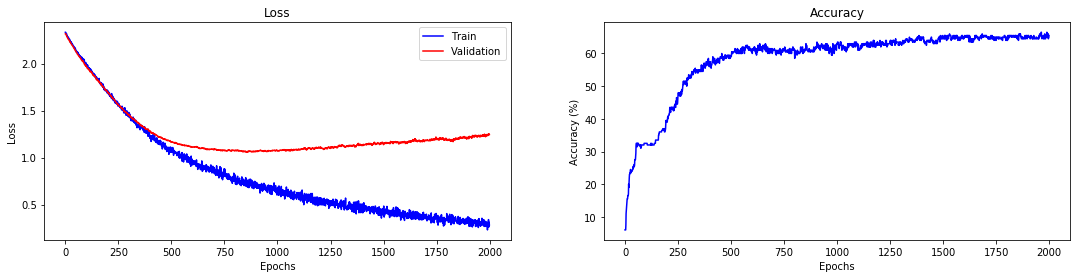

In [22]:
fig = plt.figure()
fig.subplots_adjust(right=2.5)

ax1 = fig.add_subplot(121)
ax1.set_title('Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.plot(train_losses, 'b-', label='Train')
ax1.plot(valid_losses, 'r-', label='Validation')
ax1.legend(loc='upper right')

ax1 = fig.add_subplot(122)
ax1.set_title('Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy (%)')
ax1.plot(accuracies, 'b-')

plt.show()

In [23]:
torch.save(model.state_dict(), './results/mgc_dnn_d_bn.model')

In [24]:
test_data_batches = data_batcher(test_data, valid_batch_size)
accuracy = test(model, device, test_data_batches)

Test set: Accuracy: 131/200 (65%)

